In [1]:
#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
from torch.distributions import MultivariateNormal
import pandas as pd
import time
# I use the work of Eric Yu to help me build this algorithm. Link: https://github.com/ericyangyu/PPO-for-Beginners

In [2]:
#2) Set up Neural Network functions and classes

class Model_PPO(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
    """  
    def __init__(self, np_inputs, nb_outputs):
        super(Model_PPO, self).__init__()   
        self.layer1 = nn.Linear(np_inputs, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, nb_outputs)
        torch.nn.init.uniform_(self.layer3.weight,0.003, 0.006)

    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        activation1 = F.relu(self.layer1(input1))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [3]:
#3) Rollout on the environment:

class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def reset(self):
        """
        Reset: reinitilization (lists et environment).
        """
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def iterations(self,actor_net, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch
        """
        for ep in range(nbr_episodes):
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(action.dim()==0):
                        action=torch.unsqueeze(action,dim=0)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    #action_all=np.append(action_all,np.argmax(action[1:4].detach().numpy()))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action_all)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float)
    
    def iterations_rand(self,actor_net, cov_mat, batch_size):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param cov_mat: covariance matrix used for exploration
        :param batch_size: batch size
        :return: Tensors; state batch, action batch, log_proba batch
        """
        t = 0
        while t<batch_size:
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                t += 1
                with torch.no_grad():
                    parameters_based = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(parameters_based.dim()==0):
                        parameters_based=torch.unsqueeze(parameters_based,dim=0)
                    distribution_p = MultivariateNormal(parameters_based, cov_mat)
                    action = distribution_p.sample()
                    log_proba = distribution_p.log_prob(action)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action.detach().numpy())
                    self.batch_log_probs.append(log_proba)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float), torch.tensor(self.batch_log_probs, dtype=torch.float)

    def immediate_rewards(self):
        """
        Immediate rewards
        :return: Tensor; batch reward
        """
        batch_rewards = []
        for ep_rews in self.batch_rews:
            for rew in reversed(ep_rews):
                batch_rewards.insert(0,rew)
        return torch.tensor(batch_rewards, dtype=torch.float)
    
    def futur_rewards(self):
        """
        Expected futures rewards
        :return: Tensor; batch reward-to-go
        """
        batch_rtgs = []
        for ep_rews in reversed(self.batch_rews):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs.insert(0,episodic_reward)
        return torch.tensor(batch_rtgs, dtype=torch.float)

In [12]:
#4) Algorithm DDPG:
class Algo_PPO():
    """ 
    PPO algorithm : training and testing
    :param policy_class: policy (actor model)
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class(self.num_states, self.num_actions)
        self.critic_net = policy_class(self.num_states, 1)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.cov_var = torch.full(size=(self.num_actions,), fill_value=0.50)
        self.cov_mat = torch.diag(self.cov_var)
        self.rollout = Env_rollout(env, self.max_steps)
        self.ep_reward_list=[]
    
    def evaluate(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        rew_batch = self.rollout.immediate_rewards()
        return state_batch, action_batch, rew_batch
        
    def train(self, comp_time):
        """ 
        Training
        :param comp_time: computing time
        """
        start = time.process_time()
        while time.process_time()-start<comp_time:
            state_batch,action_batch,log_prob_batch = self.rollout.iterations_rand(self.actor_net,self.cov_mat,self.batch_size)
            batch_rtgs = self.rollout.futur_rewards()
            self.nb_loop= self.nb_loop +self.batch_size
            #batch_rews = self.rollout.immediate_rewards()
            self.rollout.reset()
            for i in range(10):
                V_batch = torch.squeeze(self.critic_net(state_batch))
                advantage_batch = batch_rtgs - V_batch
                advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)
                
                parameters_batch = torch.squeeze(self.actor_net(state_batch).unsqueeze(-1))
                if(parameters_batch.dim()==1):
                        parameters_batch=torch.unsqueeze(parameters_batch,dim=1)
                distribution_p = MultivariateNormal(parameters_batch, self.cov_mat)
                log_prob_current_batch = distribution_p.log_prob(action_batch)
                ratio_batch = torch.exp(log_prob_current_batch - log_prob_batch)
                ratio_loss = torch.mul(ratio_batch,advantage_batch)
                clip_loss = torch.mul(torch.clamp(ratio_loss, 0.8, 1.2),advantage_batch)
                actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

                criterion=nn.MSELoss(reduction='mean')
                critic_loss = criterion(V_batch.float(), batch_rtgs.float())
                self.optimizer_actor.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.optimizer_actor.step()
                self.optimizer_critic.zero_grad()
                critic_loss.backward()
                self.optimizer_critic.step()
                
            state_batch, action_batch = self.rollout.iterations(self.actor_net, 30)
            batch_rews = self.rollout.immediate_rewards()
            self.ep_reward_list.append(batch_rews.mean().numpy())
            avg_reward = np.mean(self.ep_reward_list[-10:])
            self.rollout.reset()            
            print("Steps * {} , Avg Reward is ==> {} And Time is ==> {}".format(self.nb_loop,avg_reward,time.process_time()-start))
        self.total_time=time.process_time()-start
        path='load_model/parameters/ppo-{num_algo:02d}-{name}-time-{time:06d}.npy'
        with open(path.format(num_algo=self.num_algo,time=int(self.total_time),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        return self.nb_loop
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.max_steps = 90
        self.nb_loop = 0
        self.total_time=0.0
        self.batch_size = 2000
        self.gamma = 0.99
        self.critic_lr = 3e-4
        self.actor_lr = 3e-4
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: number of total batch iterations
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/ppo-{num_algo:02d}-actor-time-{time:06d}.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(time=int(total_loop), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/ppo-{num_algo:02d}-critic-time-{time:06d}.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(time=int(total_loop), num_algo=self.num_algo)))
    
    def saving(self):
        """
        Saving NN weights 
        """
        checkpoint_path = "load_model/weights/ppo-{num_algo:02d}-actor-time-{time:06d}.pth"
        torch.save(self.actor_net.state_dict(),checkpoint_path.format(time=int(self.total_time), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/ppo-{num_algo:02d}-critic-time-{time:06d}.pth"
        torch.save(self.critic_net.state_dict(),checkpoint_path.format(time=int(self.total_time), num_algo=self.num_algo)) 

In [13]:
#5) Computing part:
# Import environment
problem = "Crosswalk_comparison-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1

algo=Algo_PPO(Model_PPO, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(1,3601)

In [6]:
#Training for 1 hour
import time
nb_step=algo.train(3600)
algo.saving()
print("Steps: "+str(nb_step))

Steps * 2000 , Avg Reward is ==> -10.415046691894531 And Time is ==> 5.59375
Steps * 4000 , Avg Reward is ==> -9.698184967041016 And Time is ==> 11.421875
Steps * 6000 , Avg Reward is ==> -9.241297721862793 And Time is ==> 16.984375
Accident!
Steps * 8000 , Avg Reward is ==> -8.850469589233398 And Time is ==> 22.8125
Accident!
Steps * 10000 , Avg Reward is ==> -8.970696449279785 And Time is ==> 28.578125
Steps * 12000 , Avg Reward is ==> -8.51834774017334 And Time is ==> 34.359375
Accident!
Steps * 14000 , Avg Reward is ==> -8.460037231445312 And Time is ==> 39.921875
Accident!
Accident!
Steps * 16000 , Avg Reward is ==> -8.721753120422363 And Time is ==> 45.609375
Steps * 18000 , Avg Reward is ==> -8.801876068115234 And Time is ==> 51.046875
Steps * 20000 , Avg Reward is ==> -8.883833885192871 And Time is ==> 56.515625
Steps * 22000 , Avg Reward is ==> -8.665645599365234 And Time is ==> 61.78125
Steps * 24000 , Avg Reward is ==> -8.648380279541016 And Time is ==> 65.890625
Accident!
A

Accident!
Accident!
Accident!
Accident!
Steps * 158000 , Avg Reward is ==> -5.427027702331543 And Time is ==> 232.609375
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Steps * 160000 , Avg Reward is ==> -5.602163791656494 And Time is ==> 234.8125
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Steps * 162000 , Avg Reward is ==> -5.861631870269775 And Time is ==> 237.03125
Accident!
Steps * 164000 , Avg Reward is ==> -5.772430896759033 And Time is ==> 239.296875
Accident!
Accident!
Accident!
Accident!
Accident!
Steps * 166000 , Avg Reward is ==> -5.97230863571167 And Time is ==> 241.484375
Accident!
Accident!
Accident!
Steps * 168000 , Avg Reward is ==> -5.787757873535156 And Time is ==> 243.875
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Steps * 170000 , Avg Reward is ==> -5.3683762550354 And Time is ==> 246.09375
Accident!
Accident!
Steps * 172000 , Avg Reward is ==> -5.18288

Steps * 316000 , Avg Reward is ==> -2.338705062866211 And Time is ==> 400.25
Accident!
Steps * 318000 , Avg Reward is ==> -2.2857508659362793 And Time is ==> 402.546875
Steps * 320000 , Avg Reward is ==> -2.2866427898406982 And Time is ==> 404.6875
Accident!
Steps * 322000 , Avg Reward is ==> -2.246659278869629 And Time is ==> 406.921875
Steps * 324000 , Avg Reward is ==> -2.229408025741577 And Time is ==> 409.0625
Steps * 326000 , Avg Reward is ==> -2.1873741149902344 And Time is ==> 411.0625
Steps * 328000 , Avg Reward is ==> -2.1788690090179443 And Time is ==> 413.21875
Accident!
Steps * 330000 , Avg Reward is ==> -2.183281660079956 And Time is ==> 415.21875
Steps * 332000 , Avg Reward is ==> -2.16975736618042 And Time is ==> 417.140625
Accident!
Steps * 334000 , Avg Reward is ==> -2.145566940307617 And Time is ==> 419.28125
Steps * 336000 , Avg Reward is ==> -2.125300407409668 And Time is ==> 421.390625
Accident!
Accident!
Steps * 338000 , Avg Reward is ==> -2.1234350204467773 And 

Steps * 504000 , Avg Reward is ==> -1.4162862300872803 And Time is ==> 607.3125
Steps * 506000 , Avg Reward is ==> -1.4047253131866455 And Time is ==> 609.390625
Steps * 508000 , Avg Reward is ==> -1.3936665058135986 And Time is ==> 611.65625
Accident!
Steps * 510000 , Avg Reward is ==> -1.3900270462036133 And Time is ==> 613.765625
Steps * 512000 , Avg Reward is ==> -1.3004992008209229 And Time is ==> 616.09375
Steps * 514000 , Avg Reward is ==> -1.31305730342865 And Time is ==> 618.390625
Accident!
Steps * 516000 , Avg Reward is ==> -1.2043852806091309 And Time is ==> 620.609375
Accident!
Accident!
Steps * 518000 , Avg Reward is ==> -1.223797082901001 And Time is ==> 622.734375
Steps * 520000 , Avg Reward is ==> -1.1735384464263916 And Time is ==> 624.96875
Steps * 522000 , Avg Reward is ==> -1.1301287412643433 And Time is ==> 627.203125
Accident!
Steps * 524000 , Avg Reward is ==> -1.1063506603240967 And Time is ==> 629.578125
Steps * 526000 , Avg Reward is ==> -1.071625828742981 An

Accident!
Steps * 696000 , Avg Reward is ==> -0.7908874154090881 And Time is ==> 818.0
Accident!
Accident!
Steps * 698000 , Avg Reward is ==> -0.7889138460159302 And Time is ==> 820.34375
Accident!
Steps * 700000 , Avg Reward is ==> -0.8001132011413574 And Time is ==> 822.6875
Steps * 702000 , Avg Reward is ==> -0.8304647207260132 And Time is ==> 824.75
Steps * 704000 , Avg Reward is ==> -0.799406111240387 And Time is ==> 826.921875
Accident!
Steps * 706000 , Avg Reward is ==> -0.8073069453239441 And Time is ==> 829.0
Steps * 708000 , Avg Reward is ==> -0.8051643371582031 And Time is ==> 831.1875
Accident!
Accident!
Steps * 710000 , Avg Reward is ==> -0.77989661693573 And Time is ==> 833.3125
Steps * 712000 , Avg Reward is ==> -0.7798755764961243 And Time is ==> 835.203125
Steps * 714000 , Avg Reward is ==> -0.7884293794631958 And Time is ==> 837.140625
Steps * 716000 , Avg Reward is ==> -0.6820162534713745 And Time is ==> 839.328125
Steps * 718000 , Avg Reward is ==> -0.67244732379913

Accident!
Steps * 890000 , Avg Reward is ==> -0.7297221422195435 And Time is ==> 1030.703125
Steps * 892000 , Avg Reward is ==> -0.7276202440261841 And Time is ==> 1032.859375
Steps * 894000 , Avg Reward is ==> -0.6335439085960388 And Time is ==> 1035.0
Steps * 896000 , Avg Reward is ==> -0.6422457695007324 And Time is ==> 1037.15625
Steps * 898000 , Avg Reward is ==> -0.6315690279006958 And Time is ==> 1039.359375
Steps * 900000 , Avg Reward is ==> -0.6335386037826538 And Time is ==> 1041.546875
Steps * 902000 , Avg Reward is ==> -0.6247074007987976 And Time is ==> 1043.75
Steps * 904000 , Avg Reward is ==> -0.6412676572799683 And Time is ==> 1046.046875
Steps * 906000 , Avg Reward is ==> -0.6451606750488281 And Time is ==> 1048.375
Steps * 908000 , Avg Reward is ==> -0.6451448202133179 And Time is ==> 1050.5
Steps * 910000 , Avg Reward is ==> -0.6356922388076782 And Time is ==> 1052.78125
Steps * 912000 , Avg Reward is ==> -0.6366921663284302 And Time is ==> 1055.0625
Steps * 914000 

Steps * 1084000 , Avg Reward is ==> -0.6977095603942871 And Time is ==> 1243.921875
Steps * 1086000 , Avg Reward is ==> -0.6766615509986877 And Time is ==> 1246.046875
Accident!
Steps * 1088000 , Avg Reward is ==> -0.6835576295852661 And Time is ==> 1248.328125
Steps * 1090000 , Avg Reward is ==> -0.7097009420394897 And Time is ==> 1250.203125
Steps * 1092000 , Avg Reward is ==> -0.7304126620292664 And Time is ==> 1252.0625
Steps * 1094000 , Avg Reward is ==> -0.7274028658866882 And Time is ==> 1253.8125
Steps * 1096000 , Avg Reward is ==> -0.7308019995689392 And Time is ==> 1255.65625
Steps * 1098000 , Avg Reward is ==> -0.7558714151382446 And Time is ==> 1257.421875
Steps * 1100000 , Avg Reward is ==> -0.7412190437316895 And Time is ==> 1259.359375
Accident!
Steps * 1102000 , Avg Reward is ==> -0.7361503839492798 And Time is ==> 1261.3125
Accident!
Steps * 1104000 , Avg Reward is ==> -0.726586639881134 And Time is ==> 1263.296875
Steps * 1106000 , Avg Reward is ==> -0.738844692707061

Steps * 1276000 , Avg Reward is ==> -0.8556828498840332 And Time is ==> 1436.109375
Accident!
Accident!
Steps * 1278000 , Avg Reward is ==> -0.7702154517173767 And Time is ==> 1438.296875
Accident!
Steps * 1280000 , Avg Reward is ==> -0.7738219499588013 And Time is ==> 1440.34375
Accident!
Steps * 1282000 , Avg Reward is ==> -0.7945776581764221 And Time is ==> 1442.703125
Steps * 1284000 , Avg Reward is ==> -0.7989814877510071 And Time is ==> 1445.0
Accident!
Steps * 1286000 , Avg Reward is ==> -0.7916256785392761 And Time is ==> 1447.296875
Steps * 1288000 , Avg Reward is ==> -0.7740370631217957 And Time is ==> 1449.453125
Steps * 1290000 , Avg Reward is ==> -0.7795642614364624 And Time is ==> 1451.625
Steps * 1292000 , Avg Reward is ==> -0.6647003889083862 And Time is ==> 1453.84375
Steps * 1294000 , Avg Reward is ==> -0.6988159418106079 And Time is ==> 1456.046875
Steps * 1296000 , Avg Reward is ==> -0.7055745124816895 And Time is ==> 1458.203125
Steps * 1298000 , Avg Reward is ==> 

Steps * 1470000 , Avg Reward is ==> -0.7619627118110657 And Time is ==> 1649.21875
Steps * 1472000 , Avg Reward is ==> -0.7614465355873108 And Time is ==> 1651.5
Steps * 1474000 , Avg Reward is ==> -0.7391397356987 And Time is ==> 1653.6875
Steps * 1476000 , Avg Reward is ==> -0.7296516299247742 And Time is ==> 1655.859375
Steps * 1478000 , Avg Reward is ==> -0.7239770889282227 And Time is ==> 1658.109375
Steps * 1480000 , Avg Reward is ==> -0.7463439702987671 And Time is ==> 1660.265625
Steps * 1482000 , Avg Reward is ==> -0.7658007144927979 And Time is ==> 1662.46875
Steps * 1484000 , Avg Reward is ==> -0.7732836008071899 And Time is ==> 1664.53125
Accident!
Steps * 1486000 , Avg Reward is ==> -0.8637334108352661 And Time is ==> 1666.765625
Steps * 1488000 , Avg Reward is ==> -0.6803039908409119 And Time is ==> 1668.921875
Steps * 1490000 , Avg Reward is ==> -0.671838641166687 And Time is ==> 1671.171875
Steps * 1492000 , Avg Reward is ==> -0.6591281294822693 And Time is ==> 1673.312

Steps * 1666000 , Avg Reward is ==> -0.7541142106056213 And Time is ==> 1858.921875
Steps * 1668000 , Avg Reward is ==> -0.749956488609314 And Time is ==> 1861.078125
Steps * 1670000 , Avg Reward is ==> -0.7516053915023804 And Time is ==> 1863.328125
Steps * 1672000 , Avg Reward is ==> -0.6600443124771118 And Time is ==> 1865.375
Steps * 1674000 , Avg Reward is ==> -0.6381422877311707 And Time is ==> 1867.46875
Steps * 1676000 , Avg Reward is ==> -0.6101071834564209 And Time is ==> 1869.734375
Steps * 1678000 , Avg Reward is ==> -0.6059454679489136 And Time is ==> 1871.921875
Steps * 1680000 , Avg Reward is ==> -0.5853550434112549 And Time is ==> 1874.203125
Steps * 1682000 , Avg Reward is ==> -0.5826977491378784 And Time is ==> 1876.4375
Steps * 1684000 , Avg Reward is ==> -0.5986604690551758 And Time is ==> 1878.59375
Steps * 1686000 , Avg Reward is ==> -0.5695137977600098 And Time is ==> 1880.609375
Accident!
Steps * 1688000 , Avg Reward is ==> -0.6222335696220398 And Time is ==> 18

Steps * 1862000 , Avg Reward is ==> -0.6479571461677551 And Time is ==> 2069.3125
Steps * 1864000 , Avg Reward is ==> -0.6582697033882141 And Time is ==> 2071.484375
Steps * 1866000 , Avg Reward is ==> -0.6608586311340332 And Time is ==> 2073.78125
Steps * 1868000 , Avg Reward is ==> -0.6531198620796204 And Time is ==> 2075.96875
Steps * 1870000 , Avg Reward is ==> -0.632667064666748 And Time is ==> 2078.03125
Steps * 1872000 , Avg Reward is ==> -0.6352280974388123 And Time is ==> 2080.25
Steps * 1874000 , Avg Reward is ==> -0.6040254235267639 And Time is ==> 2082.296875
Steps * 1876000 , Avg Reward is ==> -0.5868973731994629 And Time is ==> 2084.421875
Steps * 1878000 , Avg Reward is ==> -0.5882381200790405 And Time is ==> 2086.65625
Steps * 1880000 , Avg Reward is ==> -0.5738663673400879 And Time is ==> 2088.84375
Steps * 1882000 , Avg Reward is ==> -0.5663980841636658 And Time is ==> 2090.9375
Steps * 1884000 , Avg Reward is ==> -0.5665630102157593 And Time is ==> 2093.25
Steps * 18

Steps * 2058000 , Avg Reward is ==> -0.6959162950515747 And Time is ==> 2274.6875
Steps * 2060000 , Avg Reward is ==> -0.7059771418571472 And Time is ==> 2276.78125
Accident!
Steps * 2062000 , Avg Reward is ==> -0.6727596521377563 And Time is ==> 2279.078125
Steps * 2064000 , Avg Reward is ==> -0.6616831421852112 And Time is ==> 2281.28125
Steps * 2066000 , Avg Reward is ==> -0.6582859754562378 And Time is ==> 2283.421875
Steps * 2068000 , Avg Reward is ==> -0.6513753533363342 And Time is ==> 2285.78125
Steps * 2070000 , Avg Reward is ==> -0.6930233240127563 And Time is ==> 2287.96875
Steps * 2072000 , Avg Reward is ==> -0.6900291442871094 And Time is ==> 2290.1875
Steps * 2074000 , Avg Reward is ==> -0.6900576949119568 And Time is ==> 2292.390625
Steps * 2076000 , Avg Reward is ==> -0.6854580044746399 And Time is ==> 2294.5
Steps * 2078000 , Avg Reward is ==> -0.6668351292610168 And Time is ==> 2296.734375
Steps * 2080000 , Avg Reward is ==> -0.6567537188529968 And Time is ==> 2298.96

Accident!
Steps * 2256000 , Avg Reward is ==> -0.5847970247268677 And Time is ==> 2489.0625
Steps * 2258000 , Avg Reward is ==> -0.6108232140541077 And Time is ==> 2491.1875
Steps * 2260000 , Avg Reward is ==> -0.5969727635383606 And Time is ==> 2493.390625
Steps * 2262000 , Avg Reward is ==> -0.5984312295913696 And Time is ==> 2495.59375
Steps * 2264000 , Avg Reward is ==> -0.6235626339912415 And Time is ==> 2497.828125
Steps * 2266000 , Avg Reward is ==> -0.6095634698867798 And Time is ==> 2499.96875
Accident!
Steps * 2268000 , Avg Reward is ==> -0.7034708261489868 And Time is ==> 2502.15625
Steps * 2270000 , Avg Reward is ==> -0.6820817589759827 And Time is ==> 2504.421875
Steps * 2272000 , Avg Reward is ==> -0.6928719282150269 And Time is ==> 2506.78125
Steps * 2274000 , Avg Reward is ==> -0.6811972856521606 And Time is ==> 2508.875
Steps * 2276000 , Avg Reward is ==> -0.6931465864181519 And Time is ==> 2511.0625
Steps * 2278000 , Avg Reward is ==> -0.671635627746582 And Time is ==

Steps * 2452000 , Avg Reward is ==> -0.6451150178909302 And Time is ==> 2703.5625
Steps * 2454000 , Avg Reward is ==> -0.6500013470649719 And Time is ==> 2705.703125
Steps * 2456000 , Avg Reward is ==> -0.6377226114273071 And Time is ==> 2707.96875
Steps * 2458000 , Avg Reward is ==> -0.6269926428794861 And Time is ==> 2710.0625
Steps * 2460000 , Avg Reward is ==> -0.6203283071517944 And Time is ==> 2712.171875
Steps * 2462000 , Avg Reward is ==> -0.6301825642585754 And Time is ==> 2714.375
Steps * 2464000 , Avg Reward is ==> -0.6259239315986633 And Time is ==> 2716.515625
Accident!
Steps * 2466000 , Avg Reward is ==> -0.6220198273658752 And Time is ==> 2718.5
Steps * 2468000 , Avg Reward is ==> -0.612061619758606 And Time is ==> 2720.671875
Steps * 2470000 , Avg Reward is ==> -0.6294378638267517 And Time is ==> 2722.765625
Steps * 2472000 , Avg Reward is ==> -0.6324900388717651 And Time is ==> 2724.78125
Steps * 2474000 , Avg Reward is ==> -0.5995053648948669 And Time is ==> 2726.8593

Steps * 2650000 , Avg Reward is ==> -0.735119104385376 And Time is ==> 2917.234375
Steps * 2652000 , Avg Reward is ==> -0.7437701225280762 And Time is ==> 2919.015625
Steps * 2654000 , Avg Reward is ==> -0.7248382568359375 And Time is ==> 2920.75
Steps * 2656000 , Avg Reward is ==> -0.7320845723152161 And Time is ==> 2922.578125
Steps * 2658000 , Avg Reward is ==> -0.7626950144767761 And Time is ==> 2924.390625
Steps * 2660000 , Avg Reward is ==> -0.7308553457260132 And Time is ==> 2926.140625
Steps * 2662000 , Avg Reward is ==> -0.7237528562545776 And Time is ==> 2928.015625
Steps * 2664000 , Avg Reward is ==> -0.6928291320800781 And Time is ==> 2929.734375
Steps * 2666000 , Avg Reward is ==> -0.6931759119033813 And Time is ==> 2931.546875
Steps * 2668000 , Avg Reward is ==> -0.6858084797859192 And Time is ==> 2933.3125
Steps * 2670000 , Avg Reward is ==> -0.6902678608894348 And Time is ==> 2935.1875
Steps * 2672000 , Avg Reward is ==> -0.6670383214950562 And Time is ==> 2936.875
Step

Steps * 2848000 , Avg Reward is ==> -0.6100893616676331 And Time is ==> 3103.890625
Steps * 2850000 , Avg Reward is ==> -0.618127703666687 And Time is ==> 3105.671875
Steps * 2852000 , Avg Reward is ==> -0.6453443765640259 And Time is ==> 3107.578125
Steps * 2854000 , Avg Reward is ==> -0.640925407409668 And Time is ==> 3109.28125
Steps * 2856000 , Avg Reward is ==> -0.6350806355476379 And Time is ==> 3111.0
Steps * 2858000 , Avg Reward is ==> -0.617267370223999 And Time is ==> 3112.765625
Steps * 2860000 , Avg Reward is ==> -0.6122191548347473 And Time is ==> 3114.515625
Steps * 2862000 , Avg Reward is ==> -0.6180442571640015 And Time is ==> 3116.296875
Steps * 2864000 , Avg Reward is ==> -0.5794450044631958 And Time is ==> 3118.046875
Steps * 2866000 , Avg Reward is ==> -0.5754536390304565 And Time is ==> 3119.8125
Steps * 2868000 , Avg Reward is ==> -0.5708153247833252 And Time is ==> 3121.59375
Steps * 2870000 , Avg Reward is ==> -0.5793927311897278 And Time is ==> 3123.28125
Steps

Steps * 3046000 , Avg Reward is ==> -0.5671515464782715 And Time is ==> 3286.84375
Steps * 3048000 , Avg Reward is ==> -0.554816484451294 And Time is ==> 3288.578125
Steps * 3050000 , Avg Reward is ==> -0.5610824227333069 And Time is ==> 3290.296875
Steps * 3052000 , Avg Reward is ==> -0.5747442245483398 And Time is ==> 3292.0625
Steps * 3054000 , Avg Reward is ==> -0.5589859485626221 And Time is ==> 3293.84375
Steps * 3056000 , Avg Reward is ==> -0.5585419535636902 And Time is ==> 3295.625
Steps * 3058000 , Avg Reward is ==> -0.5640600919723511 And Time is ==> 3297.328125
Steps * 3060000 , Avg Reward is ==> -0.5548983216285706 And Time is ==> 3299.078125
Steps * 3062000 , Avg Reward is ==> -0.5651594996452332 And Time is ==> 3301.25
Steps * 3064000 , Avg Reward is ==> -0.6014379262924194 And Time is ==> 3303.578125
Steps * 3066000 , Avg Reward is ==> -0.5842989683151245 And Time is ==> 3305.703125
Steps * 3068000 , Avg Reward is ==> -0.5781430006027222 And Time is ==> 3307.796875
Step

Steps * 3244000 , Avg Reward is ==> -0.8967972993850708 And Time is ==> 3516.09375
Steps * 3246000 , Avg Reward is ==> -0.8741701245307922 And Time is ==> 3518.46875
Steps * 3248000 , Avg Reward is ==> -0.8596878051757812 And Time is ==> 3520.359375
Steps * 3250000 , Avg Reward is ==> -0.8247219324111938 And Time is ==> 3522.84375
Steps * 3252000 , Avg Reward is ==> -0.7599837183952332 And Time is ==> 3525.171875
Steps * 3254000 , Avg Reward is ==> -0.7070332765579224 And Time is ==> 3527.65625
Steps * 3256000 , Avg Reward is ==> -0.7447396516799927 And Time is ==> 3530.140625
Steps * 3258000 , Avg Reward is ==> -0.7607985734939575 And Time is ==> 3532.484375
Steps * 3260000 , Avg Reward is ==> -0.6704772114753723 And Time is ==> 3534.734375
Steps * 3262000 , Avg Reward is ==> -0.6608607172966003 And Time is ==> 3537.171875
Steps * 3264000 , Avg Reward is ==> -0.6015083193778992 And Time is ==> 3539.578125
Steps * 3266000 , Avg Reward is ==> -0.6443413496017456 And Time is ==> 3542.328

In [13]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(1000)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [14]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=torch.mean(ep_reward)
    std_reward=torch.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 7.04 m/s and its standard deviation is 3.50 m/s

The average car acceleration is 0.00 m/s2 and its standard deviation is 1.68 m/s2

The average pedestrian speed is 1.00 m/s2 and its standard deviation is 0.36 m/s2

The average reward is -0.49 and its standard deviation is 2.08

The average CO2 emission is 21849.42mg and its standard deviation is 9794.48 mg

 Average End-times:
Total: 9.95 s
Car: 4.92 s
Pedestrian: 6.51 s


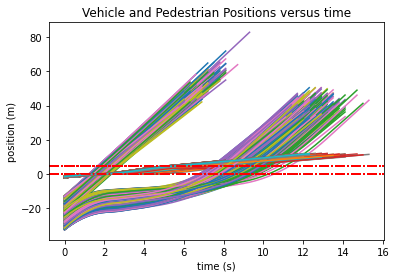

In [15]:
#Positions des agents
t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

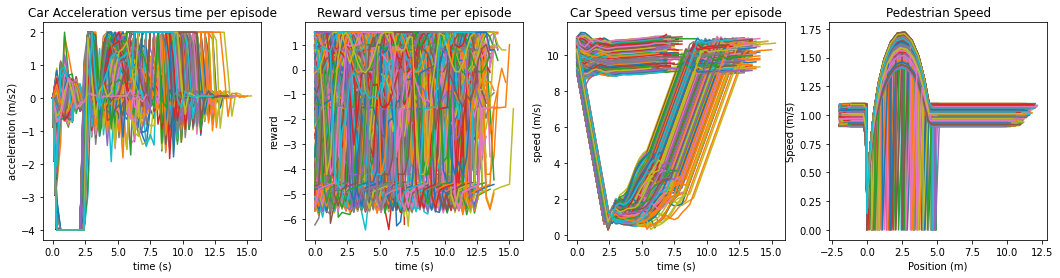

In [16]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Position (m)")
ax4.set_ylabel("Speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t],ep_speed_car[t_init:t])
    ax4.plot(states[t_init:t,4],states[t_init:t,3])
    t+=1


In [17]:
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
size_wait=17
size_cross=37

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
    if(choice):
        cross_speed.append(np.array(ep_speed_car[t_init:t_init+size_cross]))
        cross_acc.append(np.array(states[t_init:t_init+size_cross,0]))
    else:
        wait_speed.append(np.array(ep_speed_car[t_init:t_init+size_wait]))
        wait_acc.append(np.array(states[t_init:t_init+size_wait,0]))
    t+=1
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

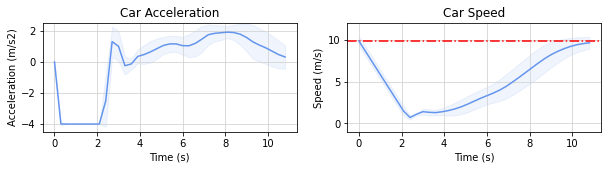

In [18]:
x1=[0.3*i for i in range(size_cross)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')


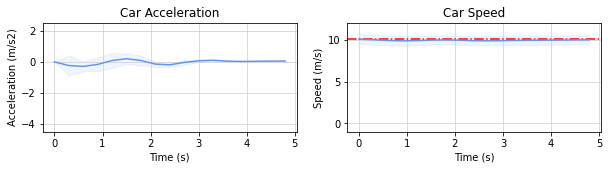

In [19]:
x1=[0.3*i for i in range(size_wait)]
mean_speed=np.mean(wait_speed,axis=0)
std_speed=np.std(wait_speed,axis=0)
mean_acc=np.mean(wait_acc,axis=0)
std_acc=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')


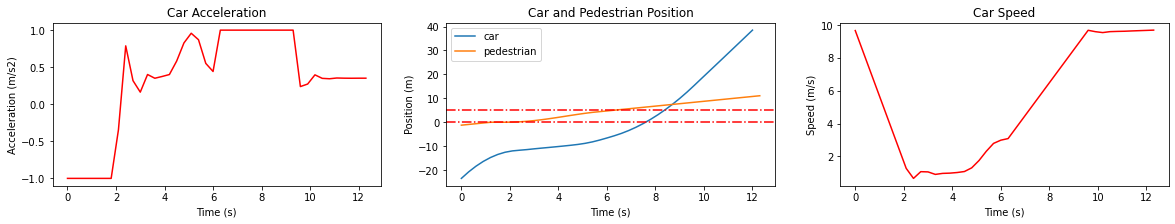

In [20]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode
#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-1.1,1.1)
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')
t+=1

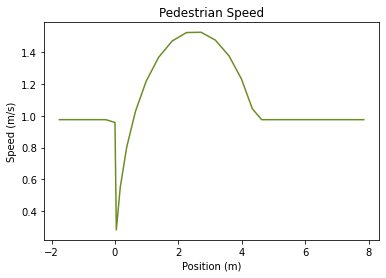

In [27]:
plt.title('Pedestrian Speed')
plt.xlabel("Position (m)")
plt.ylabel("Speed (m/s)")
plt.plot(states[t_init:t-10,4],states[t_init:t-10,3], color='olivedrab')
#plt.savefig("PDF_results/ped_speed.pdf")

In [218]:
#8) Edges Cases: 
#decided, change_speed, stops (with imminent decision)
#decided cases do not work because of the reward structure
problem = "Crosswalk_test-v0"
u_b = [2.0, 11.0, -20.0, 1.1, -1.0]
l_b = [-4.0, 9.0, -25.0, 0.9, -1.5]

env = gym.make(problem,dt=0.3,Vm=2.5,lower_bounds=l_b, upper_bounds=u_b,simulation="sin",initial_mode="change_speed")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1

algo=Algo_PPO(Model_PPO, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(1,3601)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [220]:
states, actions, rewards = algo.evaluate(2000)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

Accident!


In [19]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=torch.mean(ep_reward)
    std_reward=torch.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 5.59 m/s and its standard deviation is 3.84 m/s

The average car acceleration is 0.01 m/s2 and its standard deviation is 1.83 m/s2

The average pedestrian speed is 0.86 m/s and its standard deviation is 0.47 m/s

The average reward is -3.27 and its standard deviation is 8.94

The average CO2 emission is 25101.01mg and its standard deviation is 7768.19 mg

 Average End-times:
Total: 11.99 s
Car: 6.88 s
Pedestrian: 7.88 s


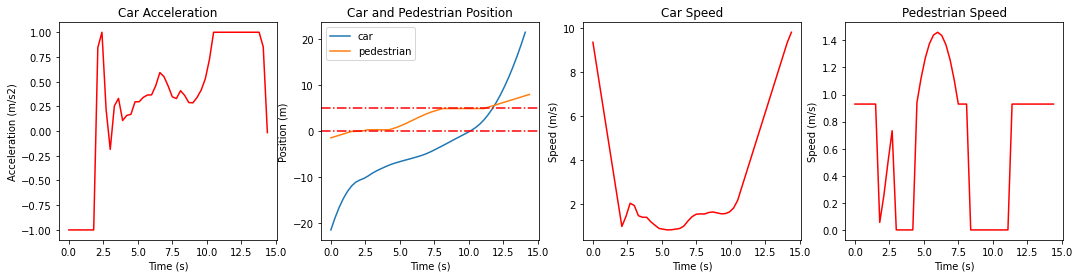

In [215]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Speed (m/s)")
ax4.plot(ep_time[t_init:t+1],ep_speed_ped[t_init:t+1],color='r')
t+=1

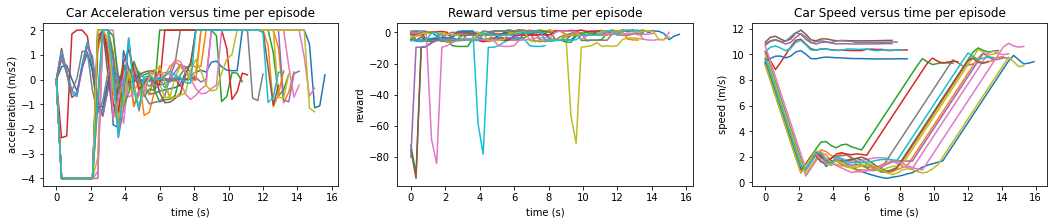

In [21]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1])
    t+=1
